<a href="https://colab.research.google.com/github/yaobviously/sym-cargo/blob/main/sym_cargo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install plotly-express --quiet
!pip install vincenty --quiet

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from vincenty import vincenty
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import plotly_express as px

In [3]:
port_file = '/content/drive/MyDrive/Ports/ports.csv'
tracking_file = '/content/drive/MyDrive/Ports/tracking.csv'

In [4]:
def wrangle():
  
  df1 = pd.read_csv(port_file)

  # converting lat and long to radians to compute haversine distance
  df1['lat_rad'] = np.radians(df1['lat'])
  df1['long_rad'] = np.radians(df1['long'])
  
  # rounding lat and long in port df
  df1['lat'] = df1['lat'].round(1)
  df1['long'] = df1['long'].round(1)

  df2 = pd.read_csv(tracking_file, parse_dates=['datetime'])
  df2 = df2.drop_duplicates()
  df2 = df2.sort_values(['vessel', 'datetime'])
  df2['vessel_1back'] = df2['vessel'].shift()
  
  # converting lat and long to radians to compute haversine distance  
  df2['lat_rad'] = np.radians(df2['lat'])
  df2['long_rad'] = np.radians(df2['long'])

  # adding lat/long column and lat/long 1 back to later compute delta
  df2['lat_long'] = [[x,y] for x, y in zip(df2['lat'], df2['long'])]
  df2['lat_long_1back'] = df2.groupby('vessel')['lat_long'].transform(lambda x: x.shift())
  
  # time deltas to compute impossible distances travelled
  df2['time_delta'] = df2.groupby('vessel')['datetime'].transform(lambda x: x - x.shift(1))
  df2['hour_delta'] = df2['time_delta'].apply(lambda x: x.seconds / 3600)

  # filtering using query to eliminate unneeded/impossible values
  df2 = df2.query('hour_delta > 0.25 & speed <30 & heading <=360 & draft < 12.5')
  df2 = df2.reset_index(drop=True)

  return df1, df2

In [5]:
df1, df2 = wrangle()

In [6]:
def vincent_distance(row):
  """ 
  returns the vincenty distance for contiguous rows - will be used to identify
  impossible distances travelled, and so on. could be used to create distance
  matrix, but this may not be worthwhile 
  """
  if row['vessel'] != row['vessel_1back']:
    return -99

  loc1 = row['lat_long']
  loc2 = row['lat_long_1back']

  try:
    distance = vincenty(loc1, loc2)
    return distance
  except:
    return -99

In [7]:
# creating a dictionary of ports with their lat and longs - will be used to
# repeatedly to explore data and assign values

ports = {port:(lat, long) for port, lat, long in zip(df1['port'], df1['lat'], df1['long'])}

# a dictionary to retrieve the port id from the index
idx_ports = {idx:port for idx, port in zip(df1.index, df1.port)}

In [8]:
# training a nearest neighbor model to  find the closest port when the 
# conditions indicating an extended stop have occurred. the metric is haversine
# in order to compute the 'great circle' distance. so i don't forget, the model
# returns the *index* of the port, not the port's identifying label

ports_train = df1[['lat_rad', 'long_rad']]

neigh_ports = NearestNeighbors(n_neighbors=3, algorithm='ball_tree', metric='haversine')
neigh_ports.fit(ports_train)

dist, n = neigh_ports.kneighbors(np.array([0.677565, 0.469731]).reshape(1,-1))

print(dist[0] * 6370)
print([idx_ports[n] for n in n[0]])

[  3.30931026  46.44757565 255.13837716]
[82, 113, 44]


In [9]:
def nearest_port(df, radius=0.01):
  """
  returns the port identifier of the nearest port using the nearest neighbors
  model 
  """

  data = np.array([df['lat_rad'], df['long_rad']]).reshape(1, -1)
  dist, pred = neigh_ports.radius_neighbors(data, radius=radius, sort_results = True) 

  if len(dist[0]) == 0:
    return -1
  
  else:
    return idx_ports[pred[0][0]]

In [10]:
def nearest_distance(df, radius=0.0125):
  """
  returns the distance of the nearest port in the dataset
  """
  
  data = np.array([df['lat_rad'], df['long_rad']]).reshape(1, -1)
  dist, pred = neigh_ports.radius_neighbors(data, radius=radius, sort_results = True) 

  if len(dist[0]) == 0:
    return -1
  
  else:
    return dist[0][0]

In [11]:
def vincenty_port(row):
  """
  a function that computes the vincenty distance between the assigned port
  and the latitude and longitude of the location data
  """
  port = row['port_coords']
  loc = row['lat_long']
  return vincenty(port, loc)

In [12]:
def train_dbscan(df=df1, eps=0.1, min_samples=2):
  """
  use the dbscan clustering algorithm to find groupss of ports

  params
  ------
      df: pandas df
      eps: min distance between points in cluster
      min_samples: min members in a cluster

  returns
  -------
      labels: labels matching index of long/lat input pairs
  """
  
  coords = df[['long_rad', 'lat_rad']].values
  db = DBSCAN(eps=eps, min_samples=min_samples, algorithm='ball_tree', metric='haversine')

  db.fit(coords)

  return db.labels_

In [13]:
# creating a dictionary of labels
df1['labels'] = train_dbscan()
db_labels = {port:cluster for port, cluster in zip(df1['port'], df1['labels'])}

In [14]:
def assign_ports(df):
  """
  prepares a dataframe for port assignment by resampling  and filtering
  it

  params:
  -----
        df: pandas dataframe
  
  returns:
  -------
        df: processed pandas dataframe

  """

  # resampling the data to standardize time intervals
  df = df.resample('4H').mean().ffill()
  df['lat_rad'] = df['lat_rad'].resample('4H').median().ffill()
  df['long_rad'] = df['long_rad'].resample('4H').median().ffill()
  
  # applying a mask to limit the rows the predict function is applied to
  mask = (df['vin_per_hour'] <= 0.75)
  df_temp = df[mask]

  df['pred_port'] = 0
  df.loc[mask, 'pred_port'] = df_temp.apply(nearest_port, axis=1)  
  df['port_coords'] = [list(ports[k]) if k in ports else -99 for k in df['pred_port']]
  df['lat_long'] = [[x,y] for x, y in zip(df['lat'], df['long'])]

  # applying a mask to limit the rows vincenty func is applied to
  vin_mask = (df['pred_port'] > 0)
  vin_temp = df[vin_mask]
  
  df['port_dist'] = 0
  df.loc[vin_mask, 'port_dist'] = vin_temp.apply(vincenty_port, axis=1)

  # eliminating entries in sequences where max distance greatly differs from min
  # indicates 'waiting to enter port'
  df['seq'] = df['pred_port'].diff().ne(0).cumsum()
  df['seq_count'] = df.groupby('seq')['seq'].transform('count')
  df['dist_diff'] = df.groupby('seq')['port_dist'].transform(lambda x: x - x.min())
  df['pred_port'] = np.where(df['dist_diff'] >= 15, 0, df['pred_port'])     # 15km away from closest point this trip to the port 

  # determining whether a block contains or is adjacent to a change in draft
  df['draft_delta_back'] = df['draft'].transform(lambda x: abs(x.diff()).ge(0.5))
  df['draft_delta_ahead'] = df['draft'].transform(lambda x: abs(x.diff(-1)).ge(0.5))
  df['sum_draft_back'] = df.groupby('seq')['draft_delta_back'].transform('sum')
  df['sum_draft_ahead'] = df.groupby('seq')['draft_delta_ahead'].transform('sum')
  df['sum_draft'] = df['sum_draft_ahead'] + df['sum_draft_back']

  # recasting vessel and pred_port columns as integers
  df[['vessel', 'pred_port']] = df[['vessel', 'pred_port']].astype(int)

  return df

In [15]:
def get_voyages(df):
  """
  a function to convert the port sequences in each dataframe into voyages
  with the proper formatting

  param:
  -----
      df: pandas DataFrame
  
  returns:
  -------
      df: processed pandas DataFrame
      
  """
  # filtering out columns without an assigned port
  nz = df[(df['pred_port'] > 0) | (df['pred_port'] == -75)].reset_index()

  vessel = nz['vessel'][0]
  dt = nz['datetime']
  pred = nz['pred_port']

  records = []

  for i in range(len(dt)-1):
    if pred[i] != pred[i+1]:
      start_port = pred[i]
      end_port = pred[i+1]
      begin_date = dt[i]
      end_date = dt[i+1]
      records.append([vessel, begin_date, end_date, start_port, end_port])

  df = pd.DataFrame.from_records(records, columns = ['vessel', 'begin_date', 'end_date', 'begin_port_id', 'end_port_id'])
  
  return df

In [16]:
# calculating the distance between each row using the vincenty function above.
# note it only calcs within each vessel group (see function). the elapsed time
# and the total distance travelled implies a speed and that speed allows for
# effetcive filtering of impossible routes

df2['vin_diff'] = df2.apply(vincent_distance, axis=1)
df2['vin_per_hour'] = df2['vin_diff'] / df2['hour_delta']
df2 = df2.query('vin_per_hour <= 50')

In [17]:
# creating a dictionary of vessel dataframes with a datetime index

vessel_dfs = {}

for vessel in df2.vessel.unique():
  df_ = df2[df2['vessel'] == vessel]
  vessel_dfs[vessel] = df_.set_index('datetime')

# assigning ports to each dataframe
processed_dfs = {f'vessel_{key}':assign_ports(vessel_dfs[key]) for key in vessel_dfs.keys()}

In [18]:
voyages_df = pd.concat([get_voyages(processed_dfs[key]) for key in processed_dfs.keys()])
voyages_df['len_voyage'] = voyages_df['end_date'] - voyages_df['begin_date']
voyages_df['begin_coords'] = [ports[key] for key in voyages_df['begin_port_id']]
voyages_df['end_coords'] = [ports[key] for key in voyages_df['end_port_id']]
voyages_df['voyage_dist'] = [vincenty(x, y) for x, y in zip(voyages_df['begin_coords'], voyages_df['end_coords'])]

In [ ]:
voyages_df.sort_values(by='voyage_dist').head(30)

In [21]:
alldf = pd.concat(processed_dfs[key] for key in processed_dfs.keys())

In [ ]:
v133 = alldf[alldf['vessel'] == ]

In [ ]:
def plot_vessel(vessel=133):

  df = alldf[alldf['vessel'] == vessel]

  df['draft'].plot(figsize=(18,5))
  df['pred_port'].plot(figsize=(18,5))

plot_vessel()

In [37]:
def plot_vessel_route(vessel=133, begin_date='2019-11-25', end_date='2019-12-21'):

  df = alldf[alldf['vessel'] == vessel]
  df = df.loc[begin_date:end_date]

  return sns.scatterplot(x=df['long'], y=df['lat'], hue='pred_port', data=df)

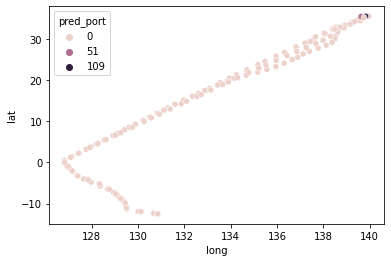

In [38]:
plot_vessel_route()

In [ ]:
def prepare_data(df, n_input = 3):
  """
  preparing the sequences for models. it was setup to be flexible but i chipped
  away at it until it returned data for an xgboost 
  """

  df = get_voyages(df)
  vessel = df['vessel'].iloc[0]
  ports_ = np.array(df['begin_port_id'].append(pd.Series(df['end_port_id'].iloc[-1])))  

  X = []
  Y = []
  start = 0

  for i in range(len(ports_)):
    last_input = start + n_input
    last_output = last_input + 3
    if last_output <= len(ports_):
      x = ports_[start:last_input]
      y = ports_[last_input: last_output]
      X.append(x)
      Y.append(y)
      start += 1
  try:
    df = pd.concat([pd.DataFrame(X),
                  pd.DataFrame(Y, columns=['port_1ahead', 'port_2ahead', 'port_3ahead'])], axis=1)
    
  except:
    df = pd.DataFrame()
    
  # X = []

  # for x in X:
  #   for n in x:
  #     if n == -75:
  #       port_coords = [33, 140]
  #     else:
  #       port_coords = list(ports[n])
  #     port = [n]
  #     port.extend(port_coords)
  #     new_X.append(port)
  
  df['vessel'] = len(df) * [vessel]
  
  return df.astype(int)

In [ ]:
model_df = pd.concat([prepare_data(processed_dfs[key], 6) for key in processed_dfs.keys()])

In [ ]:
def build_model(target='port_1ahead', min_samples=5):

  model_df = pd.concat([prepare_data(processed_dfs[key], 6) for key in processed_dfs.keys()]) 

  model_df['cluster_1back'] = [db_labels[n] for n in model_df[0]]
  model_df['cluster_2back'] = [db_labels[n] for n in model_df[1]]
  model_df['cluster_3back'] = [db_labels[n] for n in model_df[2]]

  model_df['samples'] = model_df.groupby('vessel')['vessel'].transform(lambda x: x.count())
  model_df = model_df.query('samples > @min_samples')

  features = [0, 1, 2, 3, 4, 5, 'cluster_1back', 'cluster_2back', 'cluster_3back'] 
  target = target

  X = model_df[features]
  y = model_df[target]

  model = XGBClassifier(learning_rate=0.02)
  model.fit(X, y);
  
  print(f'The model scores {model.score(X,y)}')
  
  return model

In [ ]:
build_model(target='port_3ahead')

In [ ]:
# creating a dictionary of dataframes for each port and then extracting the min,
# max, and max_draft distances for assigned ports

ports_dfs = {}

for port in alldf.pred_port.unique():
  ports_dfs[port] = alldf[alldf['pred_port'] == port]

del ports_dfs[-1]
del ports_dfs[0]

min_max = {}

for df in ports_dfs.keys():
  draft_max = ports_dfs[df].query('draft_delta >=1').port_dist.max()
  min_max[df] = [ports_dfs[df]['port_dist'].max(), ports_dfs[df]['port_dist'].min(), draft_max]

In [ ]:
fig = px.scatter_geo(alldf[alldf['vessel'] ==138], lat='lat', lon='long')

fig.show()

In [ ]:
# submissions

voyages = pd.DataFrame(columns= ['vessel', 'begin_date', 'end_date', 'begin_port_id', 'end_port_id'])
predict = pd.DataFrame(columns= ['vessel', 'begin_port_id', 'end_port_id', 'voyage'])